# EC2 Spot diversification and price history

* **Author:** Carlos Manzanedo Rueda <ruecarlo@amazon.com>
* **License:** This notebook is released under [Apache v2.0 License](https://www.apache.org/licenses/LICENSE-2.0.txt)


This jupyter notebook uses pandas and matplotlib to plot EC2 Spot historic price changes for comparison across different regions, family and instance sizes. 

The code is intended as an example of how to explore EC2 Spot historic prices. Perhaps it's obvious, but please note that historic EC2 price does not define future spot market behaviours!

When constructing a strong and EC2 Fleet, Spot Fleet or Auto Scaling Groups two of the main best practices are: (a) flexibility and (b) diversification. This jupyter notebook allows to visualise changes in the EC2 Spot historic price across regions and instance types. History goes back 3 months (EC2 Spot history API limit). This notebook intends to convey an intuition of why implementing diversification is so important with EC2 Spot as well as helping to compare different instance types and families across regions.

In [58]:
%matplotlib inline
import boto3
import requests
import datetime
from dateutil.tz import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tnrange, tqdm_notebook
from IPython.core.display import display, HTML
import ipywidgets as widgets
display(HTML("<style>.container { width:100% !important; }</style>"))

# uncomment the profile_name should you use STS and profiles
# You can read more about profiles and STS here 
# https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-role.html
#profile_name = "default"
profile_name = "admin_access"

In [59]:
%%javascript
//Some outputs may create large results. This disables the scrolling within jupyter for those. 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##  Fetching Regions and Instance types

The following section queries the regions and then queries which instance types are available in each region. This may take a few seconds up to a minute.

In [60]:
def getEC2RegionNames(profile_name=profile_name):
    session = boto3.session.Session(profile_name=profile_name)
    ec2_client = session.client('ec2')
    # exception handling
    regions_response = ec2_client.describe_regions()
    return [ region['RegionName'] for region in regions_response['Regions']]

def getInstanceTypesInRegion(profile_name=profile_name, region='us-east-1'):
    session = boto3.session.Session(profile_name=profile_name, region_name=region)
    ec2_client = session.client('ec2')
    instance_types_offering = ec2_client.describe_instance_type_offerings(LocationType='region')
    return [it['InstanceType'] for it in instance_types_offering['InstanceTypeOfferings']]
    
def getGlobalInstanceTypes(profile_name=profile_name):
    regions = getEC2RegionNames()
    instance_type_set = set([])
    for region in tqdm_notebook(regions):
        instances_types = getInstanceTypesInRegion(profile_name=profile_name, region=region)
        for instance_type in instances_types:
            instance_type_set.add(instance_type)
    return instance_type_set

regions_to_compare = sorted(getEC2RegionNames(profile_name=profile_name))
instances_to_complare = sorted(list(getGlobalInstanceTypes(profile_name=profile_name)))

# Add the regions and instances you are interested to explore
regions_w = widgets.SelectMultiple(
    options=regions_to_compare,
    value=regions_to_compare,
    description='Region:'
)
instances_w = widgets.SelectMultiple(
    options=instances_to_complare,
    value=instances_to_complare,
    description='Instance:',
    style={'height': str(30*len(instances_to_complare))}
)
days_back_w = widgets.IntSlider(
    value=30,min=1,max=90,step=1,
    description='Days back:',
)
cap_price_w = widgets.BoundedFloatText(
    value=1.0,
    min=0,
    max=40.0,
    step=0.01,
    description='Max Price',
    disabled=False
)

With all the regions and instance types, we can now provide some filtering option to select which instances types and regions will be considered as well as how far back to look in the spot price history

[Since Nov 2017 EC2 pricing model does not use bidding anymore](https://aws.amazon.com/blogs/compute/new-amazon-ec2-spot-pricing/). Some API's may still refer to it that way but the entry for bidding must be now interpreted as a max price to state how much you are willing to spend on a diversified fleet of instance types and families. This will draw a horizontal line in the charts that can help understand which instances/types will be below the max price.

In [62]:
display(widgets.HBox([widgets.VBox([days_back_w,cap_price_w]), instances_w, regions_w]),style={'height': str(60*len(instances_to_complare)) })

## Fetching Spot Historic Prices and building up the data-frames

Finally we setup our functions and start making API calls to query EC2 Spot price using the `describe_spot_price_history`.
We also define the functions that will plot the final results.

**TO-DO** The method can be optimised to search for all the instances within a region and then construct the pandas frame. At the moment is done the other way around, each instance price history is built within it's own pandas frame, re-sampled and then concatenated only when required. This increases the number of calls in the API. This shouldn't be an issue unless a comparison against many many instances is required.

In [63]:
def paginate(method, **kwargs):
    client = method.__self__
    paginator = client.get_paginator(method.__name__)
    for page in paginator.paginate(**kwargs).result_key_iters():
        for item in page:
            yield item

def fetch_spot_price_history_for_instance_in_region(region, instance, days_back=30, op_sys="Linux/UNIX", profile_name="",resolution='5T'):
    session = boto3.session.Session(profile_name=profile_name, region_name=region)
    ec2_client = session.client('ec2')
    start_time = datetime.datetime.now() - datetime.timedelta(days=days_back)
    response = ec2_client.describe_spot_price_history(
        InstanceTypes=[instance],
        MaxResults=10000,
        ProductDescriptions = [op_sys],
        StartTime=start_time)
    
    indices = None
    values = []
    for resp in paginate(ec2_client.describe_spot_price_history, InstanceTypes=[instance], ProductDescriptions = [op_sys], StartTime=start_time, MaxResults=10000):
        if indices is None:
            indices = list(resp.keys())
        values.append(list(resp.values()))
    spot_prices = pd.DataFrame(values,columns=indices)
    print("Got response for {} {} {}".format(region, instance, start_time))
    spot_prices["Timestamp"] = spot_prices['Timestamp'].astype('datetime64[ns]')
    spot_prices.set_index("Timestamp", inplace=True)
    spot_prices.tz_localize(tz=tzutc())
    spot_prices["SpotPrice"] = spot_prices.SpotPrice.astype(float)
    spot_prices.sort_index(inplace=True)
    az_df_dict = {az:pd.Series(df['SpotPrice'],name=az) for az,df in spot_prices.groupby("AvailabilityZone")}
    spot_prices = pd.concat(list(az_df_dict.values()),axis=1)
    spot_prices.loc[pd.Timestamp.now()] = spot_prices.tail(1).copy().iloc[0]
    spot_prices.fillna(method='ffill',inplace=True)
    spot_prices.fillna(method='bfill',inplace=True)
    spot_prices = spot_prices.resample(resolution).ffill()
    spot_prices.fillna(method='bfill',inplace=True)
    spot_prices.columns = [f'{instance}-{c}' for c in spot_prices]
    return spot_prices    

def fetch_spot_price_history(regions, instances, days_back=30, op_sys="Linux/UNIX", profile_name="",resolution='5T'):
    ret = {}
    for region in tqdm_notebook(regions):
        ret[region] = {}
        for instance in tqdm_notebook(instances):
            try:
                ret[region][instance] = fetch_spot_price_history_for_instance_in_region(region, instance, days_back=days_back, op_sys=op_sys, profile_name=profile_name, resolution=resolution)
            except Exception as error:
                #print("Got error when fetching {} on region {} : {}".format(instance, region, error))
                pass
    return ret

def plot_spot_prices_grid(bid_price, spot_prices_dict,instances_w,regions_w):
    region_x_pos = 0
    fig, ax = plt.subplots(len(instances_w.value),len(regions_w.value),sharex='all', sharey='all',figsize=[24,4],squeeze=False)
    plt.subplots_adjust(bottom=1,top=5)
    for region_name, inst_dic in spot_prices_dict.items():
        instance_y_pos = 0
        for instance_name, spot_price_df in inst_dic.items():
            spot_price_df.plot(ax=ax[instance_y_pos, region_x_pos])
            ax[instance_y_pos, region_x_pos].set_title("{} {}".format(region_name, instance_name))
            ax[instance_y_pos, region_x_pos].axhline(y=bid_price,linewidth=3, color='black')
            ax[instance_y_pos, region_x_pos].minorticks_on()
            ax[instance_y_pos, region_x_pos].grid(which='major', linestyle=':', linewidth='0.1',color='black')
            instance_y_pos += 1
        region_x_pos += 1

def plot_spot_aggregated_by_region(bid_price, spot_prices_dict,instances_w,regions_w, legend=True):
    region_x_pos = 0
    fig, ax = plt.subplots(1,len(regions_w.value), sharex='all', sharey='all',figsize=[30,16],squeeze=False)
    for region_name, inst_dic in spot_prices_dict.items():
        if len(inst_dic.items())==0:
            continue
        spot_history = pd.concat([v for k,v in inst_dic.items()],sort=False)
        spot_history = spot_history.resample('5T')
        spot_history = spot_history.apply(lambda x: x.fillna(method='ffill'))
        spot_history = spot_history.apply(lambda x: x.fillna(method='bfill'))    
        spot_history.plot(ax=ax[0, region_x_pos])
        ax[0,region_x_pos].set_title("{}".format(region_name))
        ax[0,region_x_pos].axhline(y=bid_price,linewidth=3, color='black')
        ax[0,region_x_pos].minorticks_on()        
        ax[0,region_x_pos].grid(which='major', linestyle=':', linewidth='0.1',color='black')
        if not legend:
            ax[0,region_x_pos].get_legend().remove()
        region_x_pos += 1

In [64]:
spot_prices_dict = fetch_spot_price_history(
    regions=regions_w.value, 
    instances=instances_w.value,
    days_back=days_back_w.value,
    profile_name=profile_name)

Got response for eu-west-1 c4.2xlarge 2019-10-18 15:58:41.080719
Got response for eu-west-1 c4.4xlarge 2019-10-18 15:58:46.756475
Got response for eu-west-1 c4.8xlarge 2019-10-18 15:58:48.896737
Got response for eu-west-1 c4.large 2019-10-18 15:58:53.201377
Got response for eu-west-1 c4.xlarge 2019-10-18 15:58:55.857224
Got response for eu-west-1 c5.12xlarge 2019-10-18 15:58:57.659535
Got response for eu-west-1 c5.18xlarge 2019-10-18 15:58:58.927166
Got response for eu-west-1 c5.24xlarge 2019-10-18 15:59:01.635834
Got response for eu-west-1 c5.2xlarge 2019-10-18 15:59:05.818476
Got response for eu-west-1 c5.4xlarge 2019-10-18 15:59:09.216861
Got response for eu-west-1 c5.9xlarge 2019-10-18 15:59:14.037781
Got response for eu-west-1 c5.large 2019-10-18 15:59:16.289917


Got response for eu-west-2 c4.2xlarge 2019-10-18 15:59:18.923394
Got response for eu-west-2 c4.4xlarge 2019-10-18 15:59:22.086996
Got response for eu-west-2 c4.8xlarge 2019-10-18 15:59:24.955906
Got response for eu-west-2 c4.large 2019-10-18 15:59:28.187988
Got response for eu-west-2 c4.xlarge 2019-10-18 15:59:31.829827
Got response for eu-west-2 c5.12xlarge 2019-10-18 15:59:35.746998
Got response for eu-west-2 c5.18xlarge 2019-10-18 15:59:39.097695
Got response for eu-west-2 c5.24xlarge 2019-10-18 15:59:43.388976
Got response for eu-west-2 c5.2xlarge 2019-10-18 15:59:46.139998
Got response for eu-west-2 c5.4xlarge 2019-10-18 15:59:50.694195
Got response for eu-west-2 c5.9xlarge 2019-10-18 15:59:53.505051
Got response for eu-west-2 c5.large 2019-10-18 15:59:56.394264


Got response for eu-west-3 c4.2xlarge 2019-10-18 15:59:59.437848
Got response for eu-west-3 c4.4xlarge 2019-10-18 16:00:00.396924
Got response for eu-west-3 c4.8xlarge 2019-10-18 16:00:01.226575
Got response for eu-west-3 c4.large 2019-10-18 16:00:02.066535
Got response for eu-west-3 c4.xlarge 2019-10-18 16:00:02.919269
Got response for eu-west-3 c5.12xlarge 2019-10-18 16:00:03.861811
Got response for eu-west-3 c5.18xlarge 2019-10-18 16:00:06.726732
Got response for eu-west-3 c5.24xlarge 2019-10-18 16:00:10.064163
Got response for eu-west-3 c5.2xlarge 2019-10-18 16:00:13.331105
Got response for eu-west-3 c5.4xlarge 2019-10-18 16:00:18.729127
Got response for eu-west-3 c5.9xlarge 2019-10-18 16:00:21.687430
Got response for eu-west-3 c5.large 2019-10-18 16:00:24.688111



## Plotting Spot price - Individual pools

`spot_prices_dict` does now contain a nested dictionary with regions and instance types as well as the EC2 Spot historic price of each ready to be explored.

Spot price can be display in multiple forms depending which type of aggregation we would like to apply
Let's apply first no grouping and just iterate over every region and every instance (every column shows a region and every row an instance). Axis are shared to allow for easy comparison.

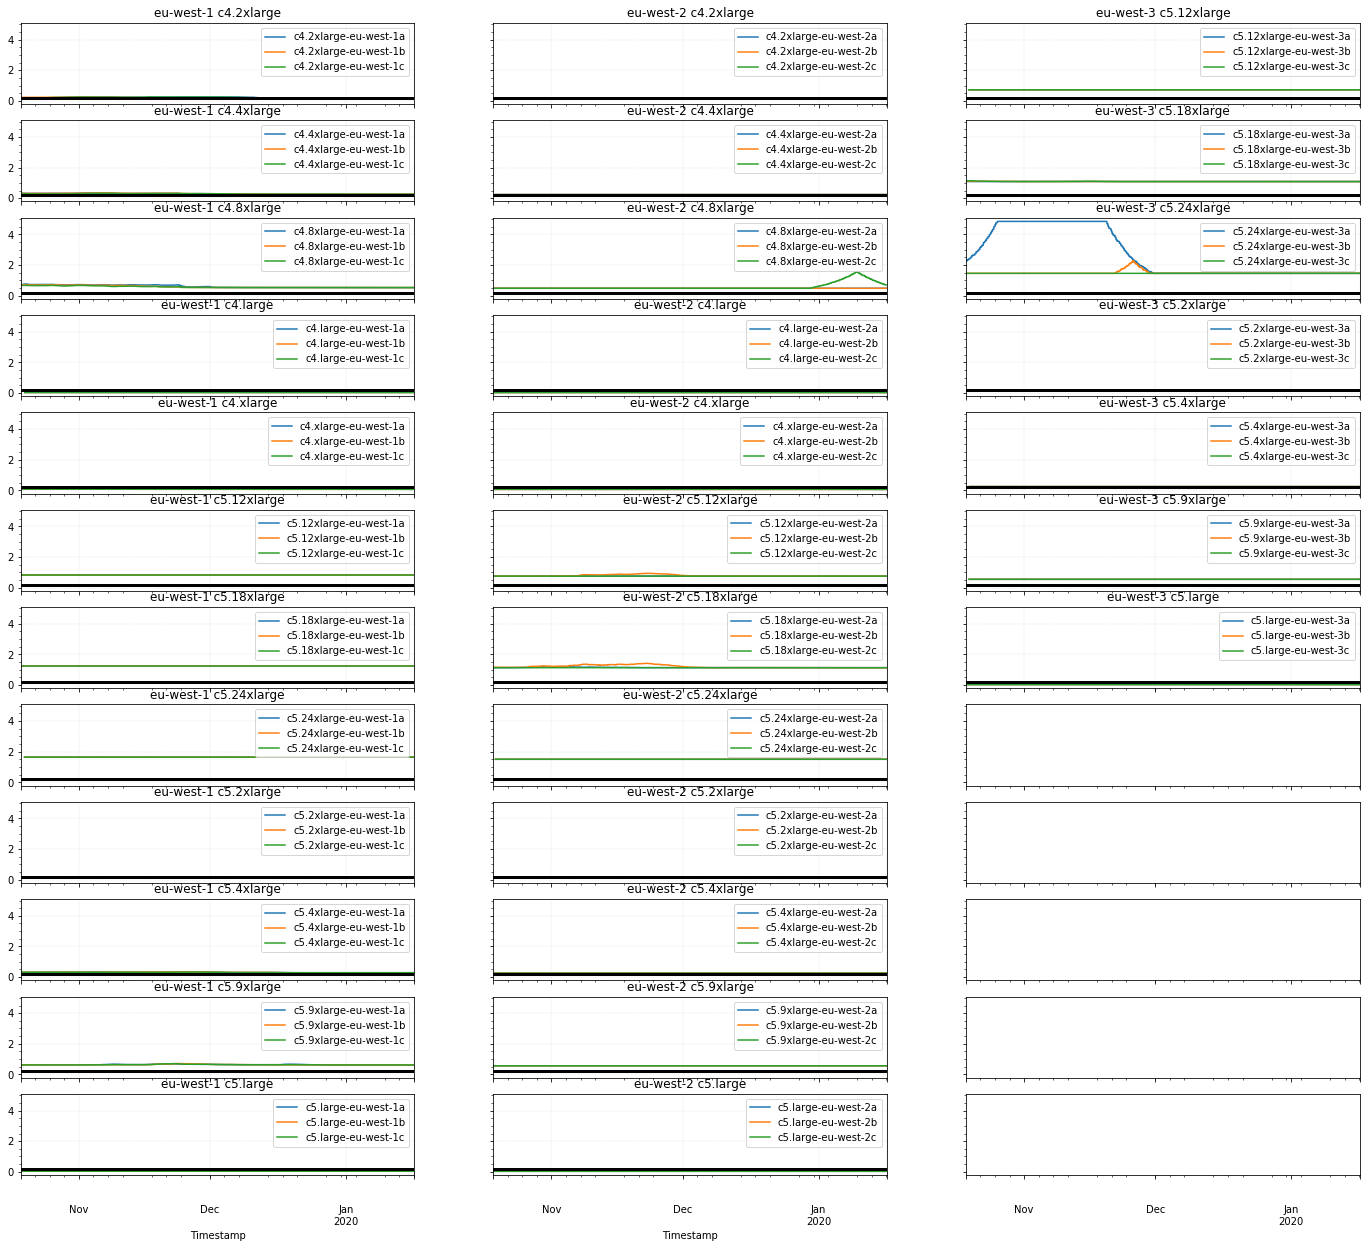

In [65]:
plot_spot_prices_grid(cap_price_w.value, spot_prices_dict,instances_w,regions_w)

## Plotting Spot price - by Region
Now let's Iterates over every region and groups all the instance types within the same region.

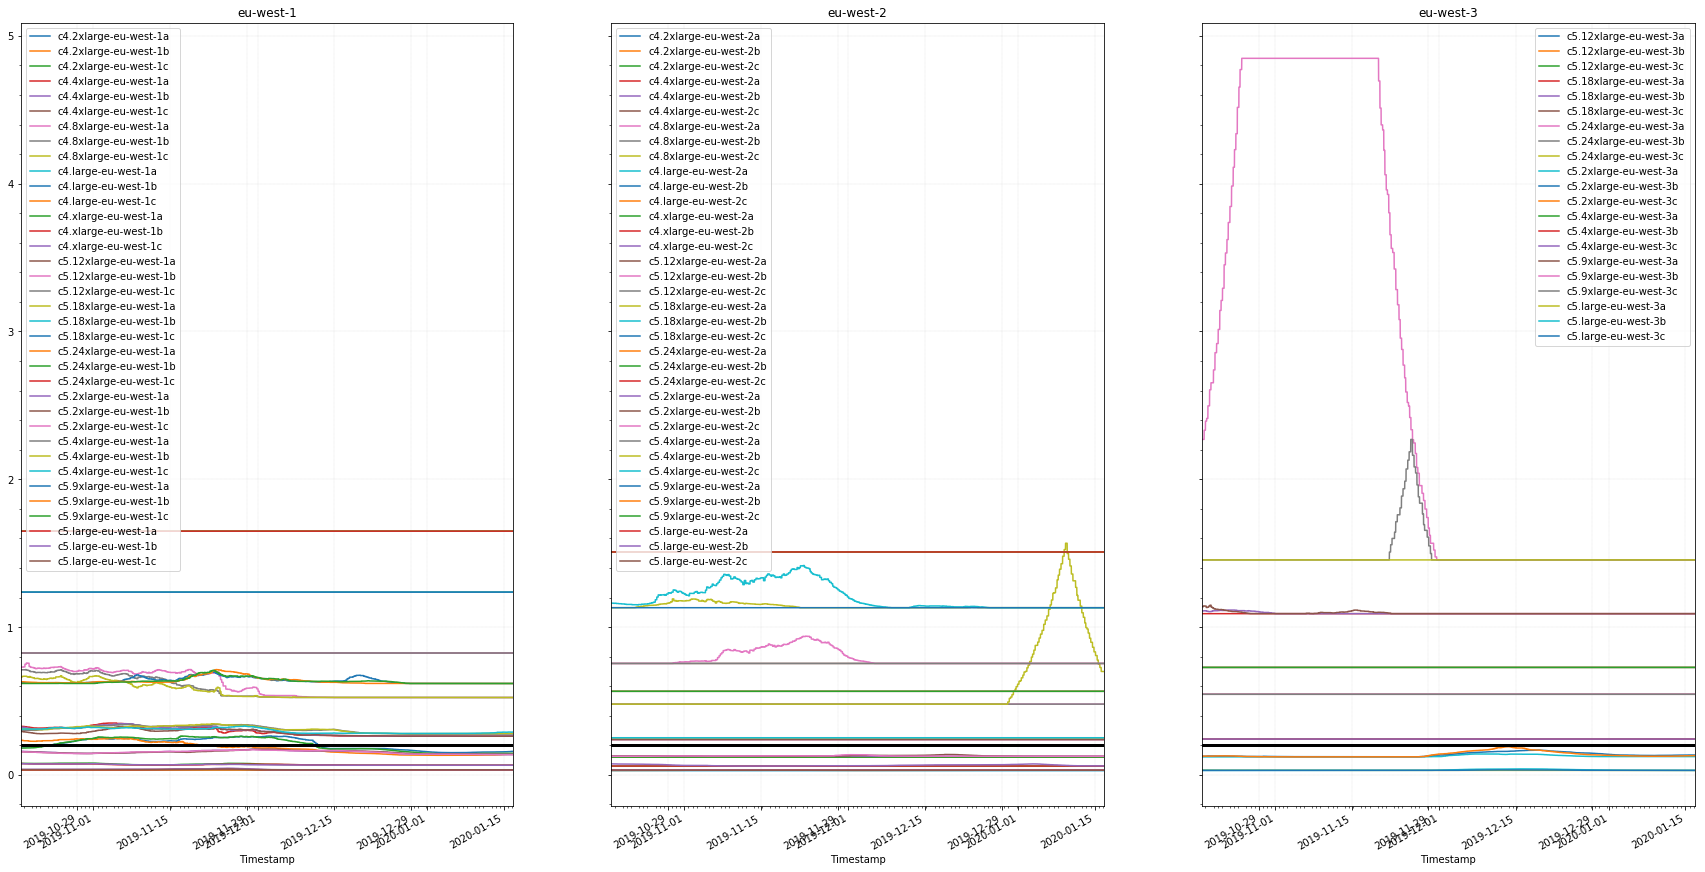

In [66]:
plot_spot_aggregated_by_region(cap_price_w.value,spot_prices_dict,instances_w,regions_w, legend=True)